# **Nombre:** Diego 
# **Apellido:** Iruretagoyena
# **Número de alumno:** 14619164

## Preguntas a responder

**1) Redes Neuronales**

1. Cargue el set de datos de miniMPII con los codigos proporcionados y el framework OpenPifPaf. Construya las matrices X e y como arreglos numpy para permitir la operacion de keras. Utilice la funcion train test split para recortar un 10% de los datos como set de test. Al entrenar con keras asigne un 20% a datos de validacion dentro de las opciones del metodo fit. Evalue la red sobre el set de test. Para considerar exitosa esta pregunta debe lograr por lo menos un 60% de precision en test. Evalue la matriz de confusion en el set de test. ¿Qué categoría es la que mejor clasifica? ¿A cual le va peor y por que?


2. En un grafico muestre la evolucion de la perdida que presenta la red en los sets de entrenamiento y de validacion, mientras que en otro muestre la evolucion de la precision de clasificacion en estos 2 sets. ¿Que nos muestran estos graficos sobre el aprendizaje de los datos?

3. Haga un estudio de sensibilidad de hiperparametros. Varıe la cantidad de capas ocultas utilizando 1 o 2 capas. Adicionalmente modifique la cantidad de neuronas en capa capa. ¿Como varıa la precision de la red a medida que aumentan o disminuyen la cantidad de capas ocultas? ¿Como varıa la precision a medida que crece o disminuye la cantidad de neuronas por capa?.



**2) Aprendizaje  Reforzado**

1. Entrene el agente de aprendizaje reforzado utilizando value iteration. Se sugiere realizar un balance de exploracion/explotacion del tipo e-greedy para simplificar los codigos. Para ello se sugiere realizar un valor cercano a los 100.000 episodios. Debe superar un acumulado de recompensa de 20 para considerar exitosa esta solucion. Verifique esto con la funcion average episodic return. Utilice la funcion animate agent para presentar una animacion del pendulo invertido con la mejor polıtica que haya podido entrenar. Utilice la discretizacion de estado sugerida en los codigos entregados.


2. Presente un grafico de la evolucion la recompensa en el tiempo durante el entrenamiento. Para ello asegurese de capturar la recompensa recibida por el agente en cada episodio, y grafique segun cada episodio. ¿Como evoluciona esta recompensa en el tiempo?



# **Empecemos**

# **Pregunta 1**

Descargamos el dataset e instalamos OpenPifPaf

In [ ]:
%%bash
gdown --id 1Lg3Bsw4tFqye2rsentjLVK7eUw2qLLD3
unzip -q mini_mpii.zip
rsync -a valid/ train/
rsync -a test/ train/
rm -r valid/ test/
mv train/ miniMPII/

Downloading...
From: https://drive.google.com/uc?id=1Lg3Bsw4tFqye2rsentjLVK7eUw2qLLD3
To: /content/mini_mpii.zip
236MB [00:01, 141MB/s]


In [ ]:
#%%bash
#rm -r sample_data/
#rm -r miniMPII/
#rm -r mini_mpii.zip
# Esto es para solucionar error "is a directory"

In [ ]:
!pip install openpifpaf==0.10.1 #última versión estable conocida

# **Actividad 6.1.1**

# **Primero, una duda... Qué es OpenPifPaf ?**



Según el paper, PifPaf es un método para estimación de poses humanas en 2D, construido para funcionar en ambientes con múltiples personas. Open ya que es Open Source.

**Y por qué se llama PifPaf ?**

"One head network predicts a confidence, precise location and size of a joint which we call a **Part Intensity Fiel (PIF)**, and the other head network predicts associations between parts, called the **Part Association Field (PAF)**. We refer to our method as PifPaf."

**Y como conclusión:**

"We have developed a new bottom-up method for
multi-person 2D human pose estimation that addresses
failure modes that are particularly prevalent in the
transportation domain, i.e., in self-driving cars and
social robots. We demonstrated that our method outperforms previous state-of-the-art methods in the low
resolution regime and performs on par at high resolution."

Venga, bueno, empecemos.


- Cargue el set de datos de miniMPII con los codigos proporcionados y el framework OpenPifPaf. 

In [ ]:
import openpifpaf
print("Versión actual de openpifpaf:", openpifpaf.__version__)

Versión actual de openpifpaf: 0.10.1


In [ ]:
#@title Carga y preparación de la red
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("usando " + "GPU" if use_cuda else "CPU")
oppnet, _ = openpifpaf.network.factory(checkpoint='resnet50')
oppnet = oppnet.to(device)
decode = openpifpaf.decoder.factory_decode(oppnet, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(oppnet, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)

usando GPU


In [ ]:
#@title Dataset class
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np 
from PIL import Image
import csv
import cv2
import random
import sys

class PosesDataset(Dataset): #Clase dataset
    def __init__(self, path, oppnet, device): #Preprocesamos las imágenes con PifPaf para obtener el esqueleto
        self.classes = sorted(os.listdir(path))
        self.classesid = {class_nom : id for (id, class_nom) in enumerate(self.classes)}
        self.length_dataset = 0
        self.skeletons = []
        self.labels = []
        self.device = device
        self.bads_route = []

        for classdir in self.classes:
            samples = os.listdir(path + '/' + classdir)
            self.length_dataset += len(samples) #Actualizamos la cantidad de imágenes del dataset

        trim_ab = np.array([[1, 0], [0, 1], [0, 0]]) #para que solo las dos primeras columnas entren en el cálculo del centro de masa
        trim__c = np.array([[0], [0], [1]]) #para extraer tan solo la tercera columna en el cálculo matricial
        current = 0
        bad = 0

        for classdir in self.classes: #Bucar en cada clase
            samples = os.listdir(path + '/' + classdir)
            samples = sorted(samples)

            for sample in samples: #Cargar cada imagen de una clase en una lista o diccionario
                route = path + '/' + classdir + '/' + sample
                img = Image.open(route)
                width, height = img.size
                if width != 640 or height != 480:
                      img = img.resize((640, 480), resample=Image.BILINEAR)

                data = openpifpaf.datasets.PilImageList([img]) #Procesamos las imágenes en un minibatch que puede ser de largo variable
                loader = DataLoader(data, batch_size=1, pin_memory=True)

                curr = 0
                for images_batch, _, __ in loader:
                    curr += 1
                    images_batch = images_batch.to(device)
                    fields_batch = processor.fields(images_batch)
                    keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
                if curr > 1:
                    print('batch mayor a uno')

                width, height = 640, 480
                cm_img = np.array([[width/2, height/2]]) #Centro de masa según el tamaño actual
                distances = []
                mass_centers = []
                threshold = 0.5 #umbral de los puntos c de los que PifPaf no está seguro

                for skeleton in keypoint_sets:
                    cm_calc = np.around(skeleton.dot(trim__c)) #Mirando únicamente la tercera columna
                    cm_calc = (np.abs(cm_calc) >= threshold).astype(float) #Usando solo los más representativos (para que los que son cero no entren en el cálculo del centro de masa)
                    cm_calc = cm_calc/sum(cm_calc) #Matriz que calcula el centro de masa
                    cm_calc = cm_calc.transpose() #necesitamos transponer para multiplicar por la izquierda
                    cm = cm_calc.dot(skeleton).dot(trim_ab) #centro de masa de los puntos visibles
                    mass_centers.append(cm)
                    dist = np.linalg.norm(cm - cm_img)
                    distances.append(dist)
                    
                current += 1 #agregamos una imagen a la cuenta

                msj = "Sampling images in {} {:.2f}% complete".format(path, current/self.length_dataset*100)
                for i in range(len(msj)):
                    sys.stdout.write('\r')
                sys.stdout.write(msj)

                if len(distances) > 0:
                    index = np.argmin(np.array(distances)) #índice del esqueleto más centrado en la foto
                    label = self.classesid[classdir]
                    self.skeletons.append(keypoint_sets[index]) 
                    self.labels.append(label)
                else: #Como parte de la metodología hay imágenes que el software no puede guardar bien, pero están en el dataset. Estas se guardan.
                    self.skeletons.append(- torch.ones((17, 3))) 
                    self.labels.append(classesid[classdir])
                    self.bads_route.append(route)
                    bad += 1

        print(" ")
        if (bad > 0):
            print("Warning: there are {} images that PifPaf could not recognize, {:.2f}% of the total".format(bad, bad/current*100))

    def get_tags(self, idx=-1):
        if idx == -1:
            return list(self.classesid.keys())
        else:
            return self.classes[idx]

    def get_class_num(self, idx):
        return self.classesid[idx]

    def __getitem__(self, idx):
        skeleton = torch.tensor(self.skeletons[idx], requires_grad=True)
        label = torch.tensor(self.labels[idx])

        return skeleton.to(self.device).view(17*3), label.to(self.device)        

    def __len__(self):
        return self.length_dataset

In [ ]:
#@title Carga del dataset
import time
import datetime
batch_size = 1
start = time.time()
train_set = PosesDataset('miniMPII', processor, device)
# valid_set = PosesDataset('valid', processor, device)
# test_set = PosesDataset('test', processor, device)
loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
stop = time.time()
print("Loading time = ", datetime.timedelta(seconds=int(stop-start)))

Sampling images in miniMPII 100.00% complete 
Loading time =  0:01:12


In [ ]:
print(train_set.get_tags())

['bicycling', 'cooking', 'rope_skipping', 'washing_car']


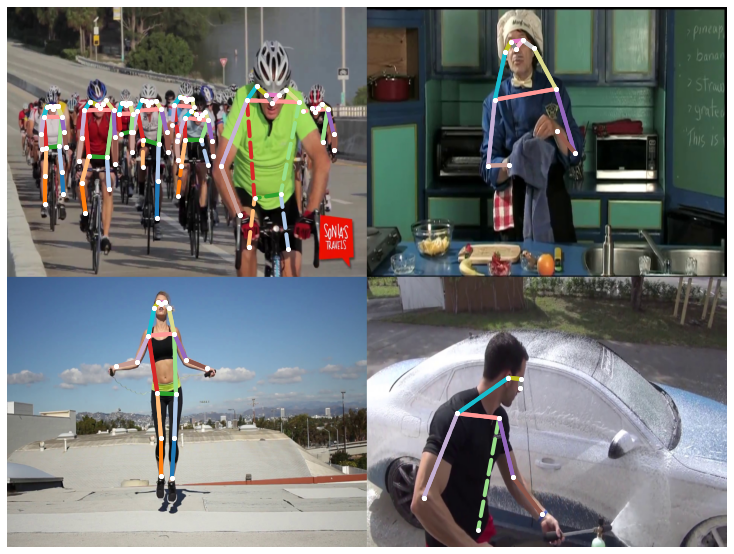

In [ ]:
import random
path = 'miniMPII'
classes = sorted(os.listdir(path))
classesid = {class_nom : id for (id, class_nom) in enumerate(classes)}

for (i, classdir) in enumerate(classes):
    samples = os.listdir(path + '/' + classdir)
    sampled = path + '/' + classdir + '/' + random.choice(samples)
    img_bgr = cv2.imread(sampled)
    height, width, channels = img_bgr.shape
    img_bgr = cv2.resize(img_bgr, (640, 480), interpolation=cv2.INTER_AREA)

    if i%2 == 0:
        row = img_bgr
    else:
        row = np.concatenate((row, img_bgr), axis=1)
        if i == 1:
            all_sampled = row
        else:
            all_sampled = np.concatenate((all_sampled, row), axis=0)

all_sampled = cv2.cvtColor(all_sampled, cv2.COLOR_BGR2RGB)
collage = Image.fromarray(all_sampled)
data = openpifpaf.datasets.PilImageList([collage])
miniloader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=4)

for images_batch, _, __ in miniloader:
  images_batch = images_batch.cuda()
  fields_batch = processor.fields(images_batch)
  predictions = processor.annotations(fields_batch[0])
  keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
  
  with openpifpaf.show.image_canvas(collage) as ax:
    keypoint_painter.annotations(ax, predictions)

# **Perceptrón Multicapa**

Ahora, utilizaremos un Perceptrón Multicapa para realizar la clasificación. Especificamente, utilizaremos los siguientes métodos:



• **model = Sequential()**

Clase de keras que le permitira ́ componer una red neuronal artificial.

• **model.add(layer)**

Me ́todo de la clase Sequential que le permitira ́ an ̃adir capas.

• **Dense(num neurons, input shape, activation) **

Clase que modela una capa densa o lineal. Nece- sita el valor num neurons como para ́metro principal que corresponde a la cantidad de neuronas de esa capa. El campo input shape solo es necesario para la primera capa y debe corresponder con la forma de la matriz de entrada (solo importa el nu ́mero de columnas o caracter ́ısticas). El campo activation hace referencia a la funcio ́n de activacio ́n que se aplica a cada una de las neuronas a la salida de la capa, algunos valores interesantes son:

- relu function
- sigmoid function
- softmax function
- softplus function
- softsign function
- tanh function
- selu function
- elu function
- exponential function


• **model.summary()** 

Entrega un resumen verbal de la composicio ́n actual de la arquitectura de la red, incluyendo la cantidad de para ́metros.

• **model.compile(loss,optimizer,metrics)**

Metodo que prepara la red para su entrenamiento, generando el grafo de computo. El campo loss define la funcio ́n de pe ́rdida del problema de optimizacio ́n, algunos valores importantes son [′categorical crossentropy′,′ binary crossentropy′,′ mean squared error′].

Nos centraremos en ′binary crossentropy′ para clasificacio ́n, que para este caso da mejor resultado ′′
que mean squared error . El campo optimizer ayudara ́ a la red a no quedarse atascada en m ́ınimos
locales, algunos valores interesantes son:
[′SGD′,′ RMSprop′,′ Adam′,′ Adagrad′]. El campo metrics entregara ́ a la red la orden de evaluar ′′
el desempen ̃o segu ́n alguna me ́trica. Por ahora solo nos interesa accuracy .


• **model.fit(X,y,epochs,batch size,verbose,validation split)**

Me ́todo que permitira ́ entrenar la red de manera supervisada para ajustar la matriz de caracter ́ısticas X al vector de etiquetas y. El para ́metro epochs hace referencia a la cantidad de veces que la red realiza el entrenamiento sobre el set de datos. El para ́metro batch size mide la cantidad de muestras que se utilizan al mismo tiempo para calcular el gradiente (mini batch). El para ́metro verbose es utilitario y nos permite vigilar el desempen ̃o en tiempo de entrenamiento. El para ́metro validation split tomara ́ una fraccio ́n de X para transformarlo en set de validacio ́n.


• **model.evaluate(X, y, verbose)**

Este me ́todo entrega una evaluacio ́n del desempen ̃o de una red pre- entrenada para un set X con etiquetas y. T ́ıpicamente esta funcio ́n se usa para evaluar el rendimiento en el set de test.


• **y = model.predict(X)**

Me ́todo que entrega un vector y de prediccio ́n de salida.


In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

X = []
y = [] 

for (data, labels) in loader:
    x_row = data.cpu().detach().numpy()
    y_row = labels.cpu().detach().numpy()
    X.extend(x_row)
    y.extend(y_row)

X = np.asarray(X)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

y_train_onehot = to_categorical(y_train, 4)
y_test_onehot = to_categorical(y_test, 4)


mlp = Sequential()

# Capa input, con tamanio igual al numero de columnas
mlp.add(Dense(50, input_shape=(51,), activation='relu', name="input_layer"))
mlp.add(Dense(40, activation='sigmoid', name="layer2"))
mlp.add(Dense(20, activation='tanh', name="layer3"))
mlp.add(Dense(4, activation='softmax', name="output_layer"))

mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 50)                2600      
_________________________________________________________________
layer2 (Dense)               (None, 40)                2040      
_________________________________________________________________
layer3 (Dense)               (None, 20)                820       
_________________________________________________________________
output_layer (Dense)         (None, 4)                 84        
Total params: 5,544
Trainable params: 5,544
Non-trainable params: 0
_________________________________________________________________


Utilice la funcio ́n train test split para recortar un 10% de los datos como set de test. 

In [ ]:
# len(X_train[0])
#len(loader)
#len(X_train)

In [ ]:
# Al entrenar con keras asigne un 20% a datos de validacio ́n dentro de las opciones del me ́todo fit.  
fit_ = mlp.fit(X_train, y_train_onehot, batch_size=32, verbose=1, epochs=30, validation_split=0.2)

Epoch 1/30
11/11 [==============================] - 0s 12ms/step - loss: 0.6305 - accuracy: 0.2241 - val_loss: 0.5364 - val_accuracy: 0.4659
Epoch 2/30
11/11 [==============================] - 0s 4ms/step - loss: 0.5209 - accuracy: 0.4454 - val_loss: 0.5183 - val_accuracy: 0.4318
Epoch 3/30
11/11 [==============================] - 0s 3ms/step - loss: 0.4878 - accuracy: 0.5115 - val_loss: 0.4977 - val_accuracy: 0.4886
Epoch 4/30
11/11 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.5460 - val_loss: 0.4936 - val_accuracy: 0.4773
Epoch 5/30
11/11 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.5776 - val_loss: 0.4697 - val_accuracy: 0.5341
Epoch 6/30
11/11 [==============================] - 0s 4ms/step - loss: 0.4442 - accuracy: 0.5805 - val_loss: 0.4630 - val_accuracy: 0.5682
Epoch 7/30
11/11 [==============================] - 0s 3ms/step - loss: 0.4310 - accuracy: 0.6121 - val_loss: 0.4487 - val_accuracy: 0.5455
Epoch 8/30
11/11 [=

In [ ]:
y_pred = mlp.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

Evalu ́e la red sobre el set de test. Para considerar exitosa esta pregunta debe lograr por lo menos un 60% de precisio ́n en test. 

In [ ]:
test_results = mlp.evaluate(X_test, y_test_onehot, verbose=1)
print('Test results - Loss: {:.4f} - Accuracy: {:.2f}%'.format(test_results[0], test_results[1]*100))

2/2 [==============================] - 0s 2ms/step - loss: 0.3341 - accuracy: 0.6939
Test results - Loss: 0.3341 - Accuracy: 69.39%


Vemos que nos da un **Accuracy de 69.39%**.

Siendo 

**accuracy score =  # Predicciones correctas / # Predicciones totales**

Además del acc_score,  nos interesa saber en que casos este se equivoca o que tan bueno es para predecir ciertas categorıas especıficas.

Para esto, usaremos una **matriz de confusion**, las cuales son construidas comparando las predicciones con las categorıas reales del set de test. 

Cada celda de la matriz contiene la cantidad de datos correspondiente a la clase indicada con el rotulo o ındice fila que fueron erroneamente clasificados como parte de la clase indicada con el rotulo o ındice columna. 




In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))


Confusion Matrix
[[11  0  2  2]
 [ 0  8  0  1]
 [ 1  1 14  1]
 [ 4  0  3  1]]


In [ ]:
print(train_set.get_tags())

['bicycling', 'cooking', 'rope_skipping', 'washing_car']


## **Reporte de clasificación**

In [ ]:
target_names = ['bicycling', 'cooking', 'rope_skipping', 'washing_car']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

    bicycling       0.69      0.73      0.71        15
      cooking       0.89      0.89      0.89         9
rope_skipping       0.74      0.82      0.78        17
  washing_car       0.20      0.12      0.15         8

     accuracy                           0.69        49
    macro avg       0.63      0.64      0.63        49
 weighted avg       0.66      0.69      0.68        49



# Matriz de confusión: Visualización con colores

Una practica comun a la hora de observar matrices de confusion es obtener una matriz normalizada con el total de los datos. Con esto cada celda representa la porcion de datos clasificados en dicha categor ́ıa contra la respuesta correcta.

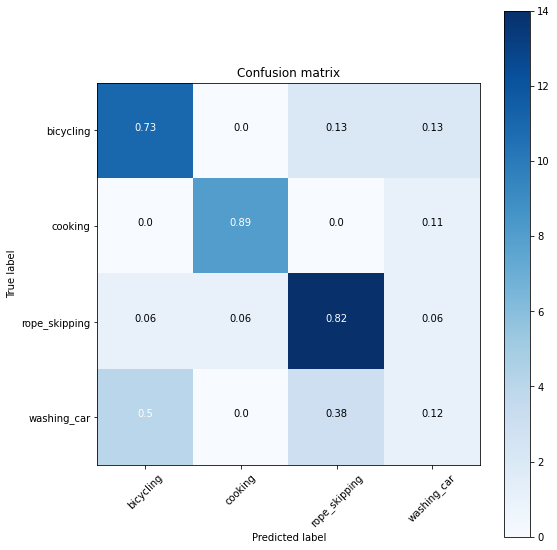

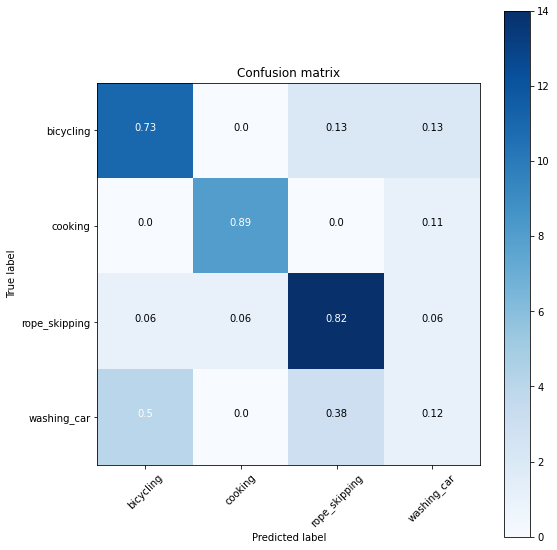

In [ ]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import itertools


def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

plot_confusion_matrix(confusion_matrix(y_test, y_pred) , ['bicycling', 'cooking', 'rope_skipping', 'washing_car'])

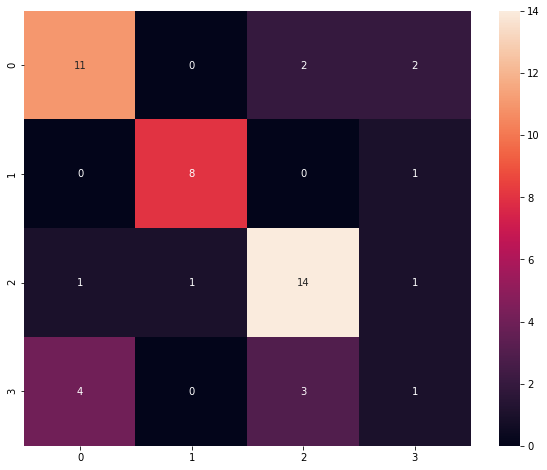

In [ ]:
# Otra opción usando heatmap y no normalizado



plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()

 **Vemos que las categorias mejor clasificadas son andar en bicicleta y cocinar. Luego, los peores son los de lavar los autos. Esto podría ser debido a la cantidad de distractores que puede haber en una foto lavando el auto vs cocinando y andar en bicicleta que son mas estandares ya que son poses muy particulares.**

## **Actividad 6.1.2: Gráfico de evolución de pérdida de la red en set de entrenamiento y validació y gráfico de evolución de la precision de clasificacion en estos 2 sets.**

**warning: Codigo del primer grafico extraido de mis clases de Reconocimiento de Patrones, dictado por el profesor Domingo Mery hace un tiempo.**

Los otros graficos, stackoverflow, links adjuntos.

displaying loss and accuracy curves...


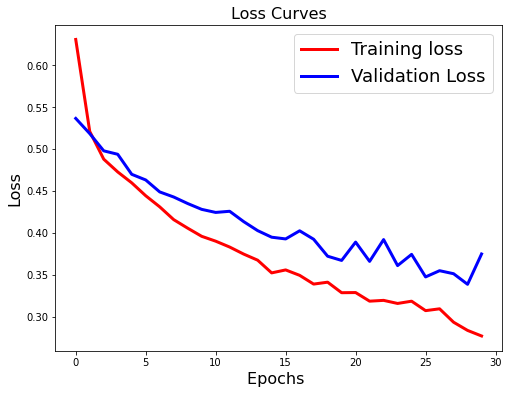

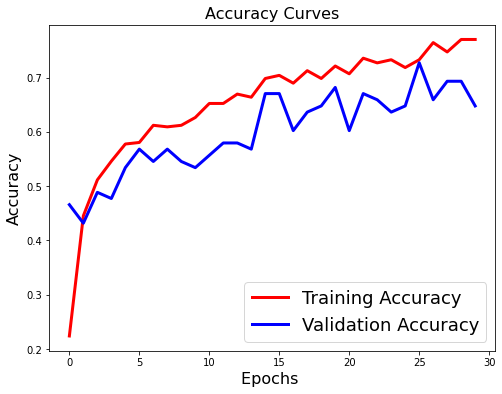

In [ ]:

def plotCurves(history):
    # loss curves
    print('displaying loss and accuracy curves...')
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    # accuracy curves
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()

plotCurves(fit_)    

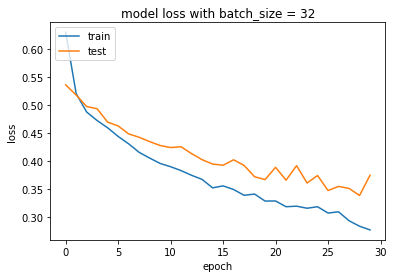

In [ ]:
# summarize history for loss
plt.plot(fit_.history['loss'])
plt.plot(fit_.history['val_loss'])
plt.title('model loss with batch_size = 32')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


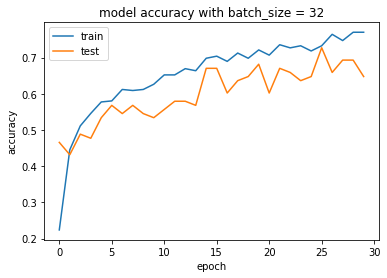

In [ ]:
plt.plot(fit_.history['accuracy'])
plt.plot(fit_.history['val_accuracy'])
plt.title('model accuracy with batch_size = 32')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


¿Que nos muestran estos graficos sobre el aprendizaje de los datos?


**Estos graficos nos indican que a medida que el numero de epocas aumenta, podemos ver una accuracy entre 0.85 y 0.90 para el set de train, mientras que para el set de test, rondamos entre 0.75 y 0.65** Cuando aumentamos el numero de epocas enormemente, podemos sobreentrenar, lo que veremos en el estudio de hiperparametros. Tambien vemos que la perdida va bajando a medida que aumentamos el numero de epocas, con valores similares en cada set.

Recordemos que el valor de perdida implica que tan bien o mal el modelo se comporta luego de cada iteración en la optimización.


# **Actividad 6.1.3: Estudio de sensibilidad de hiperparametros.**

Nota a ayudante:

Ahora realizo una simulacion iterando con

- primera_capa_neuronas = [10,20,40,60,100]

- segunda_capa_neuronas = [10,20,40,60,100, 400]

- epochs = [1, 5, 10, 15, 20, 50, 100, 150, 400]

usando las funciones 

- **simulate_one_layer(neuronas_primera_capa, epocas):**

- **simulate_two_layers(neuronas_primera_capa, segunda_capa_neuronas, epocas):**


Luego guardo los resultados y los imprimo.

No logre achicar la celda, por lo que sugiero buscar el inicio de la simulacion de dos capas buscando con CTRL + F "simulate_two_layers" 

Luego procedemos a analizar resultados.


# Una capa

In [ ]:

def simulate_one_layer(neuronas_primera_capa, epocas):
  results = []
  for neuronas_primera in neuronas_primera_capa:
      for epocs in epocas:
        mlp_ = Sequential()
        mlp_.add(Dense(50, input_shape=(51,), activation='relu', name="input_layer"))
        mlp_.add(Dense(neuronas_primera, activation='sigmoid', name="layer3"))
        mlp_.add(Dense(4, activation='softmax', name="output_layer"))
        mlp_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        mlp_.fit(X_train, y_train_onehot, batch_size=32, verbose=1, epochs=epocs, validation_split=0.2)

        y_pred = mlp_.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        test_results = mlp_.evaluate(X_test, y_test_onehot, verbose=1)

        results.append({"primera_capa": neuronas_primera, "epocs": epocs, "loss": test_results[0], "Accuracy": test_results[1]*100,})
  return results


primera_capa_neuronas = [10,20,40,60,100]
epochs = [1, 5, 10, 15, 20, 50, 100, 150, 400]

print("----------------------------------- RESULTADOS -----------------------------------")
resultados = simulate_one_layer(primera_capa_neuronas, epochs)
for result in resultados:
  print(result)
  print("\n")


Streaming output truncated to the last 5000 lines.
Epoch 249/400
11/11 [==============================] - 0s 5ms/step - loss: 0.1619 - accuracy: 0.8908 - val_loss: 0.3079 - val_accuracy: 0.7386
Epoch 250/400
11/11 [==============================] - 0s 5ms/step - loss: 0.1578 - accuracy: 0.9080 - val_loss: 0.3222 - val_accuracy: 0.7386
Epoch 251/400
11/11 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 0.8879 - val_loss: 0.3288 - val_accuracy: 0.7273
Epoch 252/400
11/11 [==============================] - 0s 5ms/step - loss: 0.1689 - accuracy: 0.8879 - val_loss: 0.3257 - val_accuracy: 0.7159
Epoch 253/400
11/11 [==============================] - 0s 5ms/step - loss: 0.1636 - accuracy: 0.9052 - val_loss: 0.3180 - val_accuracy: 0.7386
Epoch 254/400
11/11 [==============================] - 0s 4ms/step - loss: 0.1604 - accuracy: 0.9023 - val_loss: 0.3108 - val_accuracy: 0.7159
Epoch 255/400
11/11 [==============================] - 0s 5ms/step - loss: 0.1628 - accurac

# Dos capas

In [ ]:
def simulate_two_layers(neuronas_primera_capa, neuronas_segunda, epocas):
  results = []
  for neuronas_primera in neuronas_primera_capa:
    for neuronas_sgda in neuronas_segunda:
      for epocs in epocas:
        mlp_ = Sequential()
        mlp_.add(Dense(50, input_shape=(51,), activation='relu', name="input_layer"))
        mlp_.add(Dense(neuronas_primera, activation='sigmoid', name="layer3"))
        mlp_.add(Dense(neuronas_sgda, activation='tanh', name="layer4"))
        mlp_.add(Dense(4, activation='softmax', name="output_layer"))
        mlp_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        mlp_.fit(X_train, y_train_onehot, batch_size=32, verbose=1, epochs=epocs, validation_split=0.2)

        y_pred = mlp_.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        test_results = mlp_.evaluate(X_test, y_test_onehot, verbose=1)

        results.append({"primera_capa": neuronas_primera, "segunda_capa": neuronas_sgda, "epocs": epocs, "loss": test_results[0], "Accuracy": test_results[1]*100,})
  return results


primera_capa_neuronas = [10,20,40,60,100]
segunda_capa_neuronas = [10,20,40,60,100]
epochs = [1, 5, 10, 15, 20, 50, 100, 300]

print("----------------------------------- RESULTADOS -----------------------------------")
resultados = simulate_two_layers(primera_capa_neuronas, segunda_capa_neuronas, epochs)
for result in resultados:
  print(result)
  print("\n")

Streaming output truncated to the last 5000 lines.
Epoch 136/300
11/11 [==============================] - 0s 7ms/step - loss: 0.0773 - accuracy: 0.9483 - val_loss: 0.3831 - val_accuracy: 0.7045
Epoch 137/300
11/11 [==============================] - 0s 5ms/step - loss: 0.0814 - accuracy: 0.9397 - val_loss: 0.4301 - val_accuracy: 0.6932
Epoch 138/300
11/11 [==============================] - 0s 5ms/step - loss: 0.1081 - accuracy: 0.9167 - val_loss: 0.3263 - val_accuracy: 0.7386
Epoch 139/300
11/11 [==============================] - 0s 5ms/step - loss: 0.1041 - accuracy: 0.9224 - val_loss: 0.3566 - val_accuracy: 0.7273
Epoch 140/300
11/11 [==============================] - 0s 6ms/step - loss: 0.0923 - accuracy: 0.9397 - val_loss: 0.3066 - val_accuracy: 0.7386
Epoch 141/300
11/11 [==============================] - 0s 5ms/step - loss: 0.0822 - accuracy: 0.9368 - val_loss: 0.3504 - val_accuracy: 0.7614
Epoch 142/300
11/11 [==============================] - 0s 5ms/step - loss: 0.0875 - accurac

**¿Co ́mo var ́ıa la precisio ́n de la red a medida que aumentan o disminuyen la cantidad de capas ocultas? ¿Co ́mo var ́ıa la precisio ́n a medida que crece o disminuye la cantidad de neuronas por capa?**


Al tener una capa, tenemos malos resultados de accuracy cuando colocamos numeros muy bajos de epocas. A medida que aumentamos las epocas, obtenemos mejores resultados. Teniendo una capa, los mejores resultados los obtenemos cuando el numero de neuronas aumenta, aunque llegamos a un momento en que empezamos a ver overfitting. Existe un tradeoff entre muchas/pocas neuronas vs muchas/pocas epocas. Usualmente, cercano a 30 epocas y 40-70 neuronas, obtenemos los mejores resultados   

En el caso de dos capas, vemos el mismo efecto de tener cantidades minimas de epocas, al igual que con una. Ademas, vemos que al tener dos capas y un numero bajo de neuronas en la primera, y alto en la segunda, o viceversa, tiene peores resultados que tener numeros relativamente altos en ambas.

El resultado

'primera_capa': 100, 'segunda_capa': 60, 'epocs': 10, 'loss': 0.28353795409202576, 'Accuracy': 83.67347121238708}

es uno de los mejores que vemos sin llegar a generar overfitting.

En general, vemos que si tenemos pocas neuronas y solo aumentamos capas, el resultado o empeora o se mantiene, a lo mas. Cuando vamos subiendo el numero de neuronas, vemos que obtenemos mejores accuracies.


# **Pregunta 2: OpenAI Gym**

**OpenAI Gym** es un toolkit de codigo abierto, desarrollado por la empresa OpenAI.

Este toolkit es muy util para desarrollar algoritmos de aprendizaje reforzado. 

Su documentacion la pueden encontrar en https: //gym.openai.com/docs/. 

Gym posee varios ambientes con diferentes objetivos referidos a su problematica. Cada uno se carga con el metodo make de la clase gym. 

Este metodo devuelve una clase de ambiente, que denominaremos env. Esta clase permite simular el ambiente en lo que se conoce como episodios. Cada episodio consta de una secuencia de pasos, cada uno de los cuales se puede acceder por medio del metodo step. Este metodo devuelve una observacion que es una medicion del estado del ambiente en un arreglo multidimensional (con tantas dimensiones como variables de estado se tenga). 

Tambien devuelve un valor de recompensa, y un booleano que identifica si el episodio ha terminado o no (se ha llegado a un estado final). 

Este metodo recibe una accion que puede ejecutar el agente para cambiar al ambiente de estado y recibir la informacion mencionada.


**Preguntas a resolver**

1.

Entrene el agente de aprendizaje reforzado utilizando value iteration. 
Se sugiere realizar un balance de exploracion/explotacion del tipo e-greedy para simplificar los co ́digos. Para ello se sugiere realizar un valor cercano a los 100.000 episodios. 

Debe superar un acumulado de recompensa de 20 para considerar exitosa esta solucion. Verifique esto con la funcion average episodic return. 

Utilice la funcion animate agent para presentar una animacion del pendulo invertido con la mejor polıtica que haya podido entrenar. 

Utilice la discretizacion de estado sugerida en los codigos entregados.



2.

Presente un grafico de la evolucion la recompensa en el tiempo durante el entrenamiento. 

Para ello asegurese de capturar la recompensa recibida por el agente en cada episodio, y grafique segun cada episodio. 

¿Como evoluciona esta recompensa en el tiempo?


**Empecemos**

In [ ]:
#Descarga del ambiente (RUN ME!)
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
apt-get update > /dev/null 2>&1
apt-get install cmake > /dev/null 2>&1
pip install --upgrade setuptools 2>&1
pip install ez_setup > /dev/null 2>&1
pip install gym[atari] > /dev/null 2>&1

ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2


In [ ]:
#@title Importes (RUN ME TOO!)
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# init env
env = gym.make('CartPole-v1')

In [ ]:
obs = env.reset()
print(obs)

[-0.04560422 -0.04124591  0.02880042 -0.03747207]


Estos son los estados de ciertas variables importantes, para el ambiente. En ese caso estamos utilizando el ambiente ```CartPole-v1```. Según la [wiki](https://github.com/openai/gym/wiki/CartPole-v0) del toolkit las observaciones del sistema son: <p>

>Num | Observations | Min | Max
>--- | --- | ---  | ---
>0 | Cart Position | -2.4 | 2.4
>1 | Cart Velocity | -Inf | Inf
>2 | Pole Angle | ~-41.8° | ~41.8°
>3 | Pole Velocity at tip | -Inf | Inf


In [ ]:
print('Su espacio de acciones es', env.action_space)

Su espacio de acciones es Discrete(2)


En pocas palabras

>Num | Action
>--- | --- 
>0 | Push car to left
>1 | Push car to right

Cada vez que se carga el ambiente se inicializa en algún estado aleatorio, con el péndulo en posición vertical. Veamos dos ejemplos.

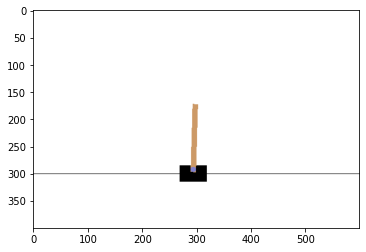

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'));

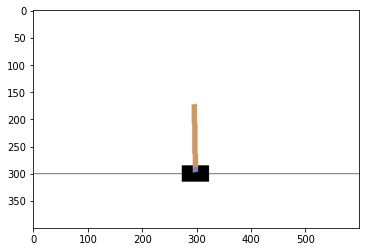

In [ ]:
env.reset()
plt.imshow(env.render(mode='rgb_array'));

La diferencia es sutil, esto pues este ambiente tiene un desafío como diseño. Hay que mantener el péndulo vertical tanto como se pueda. Luego de eso el ambiente termina. <br>
Ambientes como éste se denominan episódicos. Y tienden a funcionar en series de episodios. Muchos juegos caen en esta categoría, juegos de atari como pacman, o incluso juegos analógicos como el ajedrés también son episódicos.<br>
Los episodios de este ambiente terminan si:


*   El ángulo del péndulo es mayor a $\pm 12°$
*   La posición del carro es mayor a $\pm 2.4$
*   El largo del episodio es mayor a 500



Cada ambiente puede enviar una secuencia de acciones aleatorias si se le desea.


In [ ]:
[env.action_space.sample() for _ in range(10)]

[0, 1, 0, 0, 0, 1, 0, 1, 0, 1]

In [ ]:
# Calculemos cuantas acciones de "ir a la izquierda" puede tomar en promedio el sistema antes de que termine el episodio.
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env, 0) for _ in range(100)])

9.32

In [ ]:
# De la misma manera se puede definir un criterio que calcule la cantidad de recompensas que se pueden obtener por episodio en promedio.
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

In [ ]:
def agent_left(observation):
    return {"Action":0}

In [ ]:
average_episodic_return(env, agent_left)

{'AverageEpisodicReturn': 9.1, 'StandardDeviation': 0.7000000000000001}

In [ ]:
# De la misma forma que pudimos mostrar una imagen de un estado del agente se puede presentar al agente en una secuencia animada.

from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
# ¿Cómo se ve el agente cuando se le da la orden de ir siempre a la izquierda?

def agent_left(observation):
    return {"Action":0}
  
animate_agent(env, agent_left, max_steps = 400)

In [ ]:
# ¿Y si se envía una orden aleatoria para que se mueva a izquierda o derecha?


def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

average_episodic_return(env, agent_random)

{'AverageEpisodicReturn': 21.6, 'StandardDeviation': 6.232174580353153}

In [ ]:
animate_agent(env, agent_random)

In [ ]:
# Intentemos entrenar el agente utilizando Value Iteration.

def state_for(observation):
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-0.3, 0.375, 0.075)[:9], np.arange(-1, 1.25, 0.25)]
    state = np.zeros((3,)) #Ignorando el primer sensor
    for i, (obs, limits) in enumerate(zip(observation[1:], ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)

    return int(currstate)

In [ ]:
#@title  animate_agentVi


def agentVi(observation):
    return {"Action":np.random.choice([0, 1])}

In [ ]:
animate_agent(env, agentVi)

In [ ]:
average_episodic_return(env, agentVi)

{'AverageEpisodicReturn': 20.3, 'StandardDeviation': 6.914477565225012}

# **Pregunta 6.2.1**


1. Entrene el agente de aprendizaje reforzado utilizando value iteration. Se sugiere realizar un balance de exploracion/explotacion del tipo e-greedy para simplificar los codigos. 

Para ello se sugiere realizar un valor cercano a los 100.000 episodios. Debe superar un acumulado de recompensa de 20 para considerar exitosa esta solucion.

Verifique esto con la funcion average episodic return. Utilice la funcion animate agent para presentar una animacion del pendulo invertido con la mejor politica que haya podido entrenar. Utilice la discretizacion de estado sugerida en los codigos entregados.



2. Presente un grafico de la evolucion la recompensa en el tiempo durante el entrenamiento. Para ello asegurese de capturar la recompensa recibida por el agente en cada episodio, y grafique segun cada episodio. 

¿Como evoluciona esta recompensa en el tiempo?

**<H2> Value iteration</H2>**
Inicializar un arreglo $V$ arbitrario (por ejemplo, $V(s) = 0, \forall s \in S$<p>
Repetir <br>
$\quad \triangle \leftarrow 0$<br>
$\quad $ Para todos los $s \in S$<br>
$\quad \quad v \leftarrow V(s)$<br>
$\quad \quad V(s) \leftarrow \sum_a \pi(a|s) \sum_{s', r} p(s', r|s, \pi(s))[r+ \gamma V(s')]$<br>
$\quad \quad \triangle \leftarrow \max(\triangle, |v- V(s)|)$<br>
Hasta $\triangle < \theta$ (pequeño incremento positivo)<p>
Devolver una política determinista $\pi \approx \pi_*$ tal que<br>
$\pi(s) = argmax_a \sum_{s', r} p(s', r|s, a)[r+ \gamma V(s')]$<br>

In [ ]:
import numpy as np



def agentVi(observation):
  state = state_for(observation)
  action, probs = agent(state)
  # Convergencia de Vs
  obs, rewards, done, _ = env.step(action)
  return {"Action":np.random.choice([0, 1])}


animate_agent(env, agentVi)

NameError: ignored

In [ ]:
average_episodic_return(env, agentVi)

In [ ]:
import numpy as np

Vs = np.array(0)
Qs = np.array(0)

obs = env.reset()


for i in range(100000):
  while True:
    state = state_for(obs)
    action, probs = agent(state)
    # Convergencia de Vs
    obs, rewards, done, _ = env.step(action)

    if done:
      break
  if delta < theta:
    break

NameError: ignored

# **Pregunta 6.2.2**

Presente un grafico de la evolucion la recompensa en el tiempo durante el entrenamiento. 

Para ello asegurese de capturar la recompensa recibida por el agente en cada episodio, y grafique segun cada episodio.

 ¿Co ́mo evoluciona esta recompensa en el tiempo?